<a href="https://colab.research.google.com/github/rwydaeghe/smartwindows/blob/master/Poisson_equation_using_Fenics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Configure Fenics on google colab

In [1]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/graphic

In [0]:
from dolfin import *
import matplotlib.pyplot as plt
import time
from matplotlib.tri import Triangulation, CubicTriInterpolator, UniformTriRefiner
import matplotlib.cm as cm
import numpy as np

In [0]:
t = time.clock()

# Classes for different electrodes
class E1(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 0.0) and between(x[0], (0.0,4.0e-5)))

class E2(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 0.0) and between(x[0], (8.0e-5,12.0e-5))) 

class E3(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 5.0e-5) and between(x[0], (4.0e-5,8.0e-5)))

class E4(SubDomain):
  def inside(self, x, on_boundary):
    return (near(x[1], 5.0e-5) and between(x[0], (12.0e-5,16.0e-5)))

# Initialize sub-domain instances
e1 = E1()
e2 = E2()
e3 = E3()
e4 = E4()
  


In [0]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary to left boundary 
    def map(self, x, y):
        y[0] = x[0] - 16.0e-5
        y[1] = x[1]

# Create periodic boundary condition
pbc = PeriodicBoundary()

In [5]:
# Create mesh and finite element
p0 = Point(0.0,0)
p1 = Point(16.0e-5,5.0e-5)
mesh = RectangleMesh(p0,p1,1600,500)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=pbc)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)


Calling FFC just-in-time (JIT) compiler, this may take some time.


In [0]:
# Define Dirichlet boundary conditions for the four electrodes
bcs = [DirichletBC(V, 1.0e-5, e1), DirichletBC(V, 1.0e-5, e2), DirichletBC(V, 1.0e-5, e3), DirichletBC(V, 1.0e-5, e4),]

In [0]:
a = dot(grad(u), grad(v))*dx
L = f*v*dx

In [8]:
# Compute solution
u = Function(V)
solve(a == L, u, bcs)
print(time.clock()-t)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
60.813837


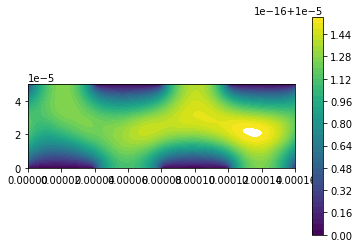

In [9]:
# Plot solution
c = plot(u)
plt.colorbar(c)

Plotting and computing electrical field using matplotlib

In [0]:
mesh = u.function_space().mesh()
z = u.compute_vertex_values(mesh)
x = mesh.coordinates()[:,0]
y = mesh.coordinates()[:,1]
t = mesh.cells()
triang = Triangulation(x,y,t)

In [0]:
# computing gradient
tci = CubicTriInterpolator(triang, -z)
(Ex, Ey) = tci.gradient(triang.x, triang.y)
E_norm = np.sqrt(Ex**2 + Ey**2)

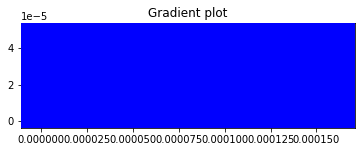

In [12]:
# Plot triangulation, potential and vector field
fig, ax = plt.subplots()
ax.set_aspect('equal')
# Enforce the margins, and enlarge them to give room for the vectors.
ax.use_sticky_edges = False
ax.margins(0.07)

ax.triplot(triang, color='0.8')

#levels = np.arange(0., 1., 0.01)
cmap = cm.get_cmap(name='hot', lut=None)
ax.tricontour(x, y, z, cmap=cmap)
# Plots direction of the electrical vector field
ax.quiver(triang.x, triang.y, Ex/E_norm, Ey/E_norm,                              # todo: nu teveel arrows om te plotten -> ziet enkel blauw -> aanpassen enkel voor figuur
          units='xy', scale=10., zorder=3, color='blue',
          width=0.007, headwidth=3., headlength=4.)

ax.set_title('Gradient plot')
plt.show()

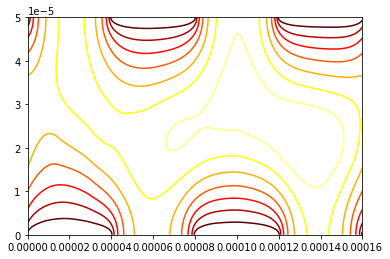

In [13]:
plt.tricontour(x, y, z, cmap=cmap)
